In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(textshape))
suppressMessages(library(circlize))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))

In [2]:
set.seed(42)
getwd()

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/Figures/Main/Fig3/Final_panels_V2"

In [3]:
obj <- readRDS("../../../../final_results/integrated_visium/integrated_slides_ann_v2.rds")
obj

An object of class Seurat 
39021 features across 91517 samples within 4 assays 
Active assay: Spatial (19325 features, 0 variable features)
 3 other assays present: SCT, dorothea, progeny
 5 dimensional reductions calculated: pca, harmony, umap_harmony, umap_original, umap_harmony_v2

In [7]:
obj$mol_niche <- stringr::str_replace_all(obj$mol_niche,
                                         c("niche_11" = "niche 12",
                                          "niche_10" = "niche 11",
                                          "niche_9" = "niche 10",
                                          "niche_8" = "niche 9",
                                          "niche_7" = "niche 8",
                                          "niche_6" = "niche 7",
                                          "niche_5" = "niche 6",
                                          "niche_4" = "niche 5",
                                          "niche_3" = "niche 4",
                                          "niche_2" = "niche 3",
                                          "niche_1" = "niche 2",
                                          "niche_0" = "niche 1"))

In [8]:
cols <- ArchR::paletteDiscrete(unique(obj$mol_niche))
cols

niche 1   niche 2   niche 3   niche 4   niche 5   niche 6   niche 7   niche 8 
"#D51F26" "#272E6A" "#208A42" "#89288F" "#F47D2B" "#FEE500" "#8A9FD1" "#C06CAB" 
  niche 9  niche 10  niche 11  niche 12 
"#D8A767" "#90D5E4" "#89C75F" "#F37B7D"

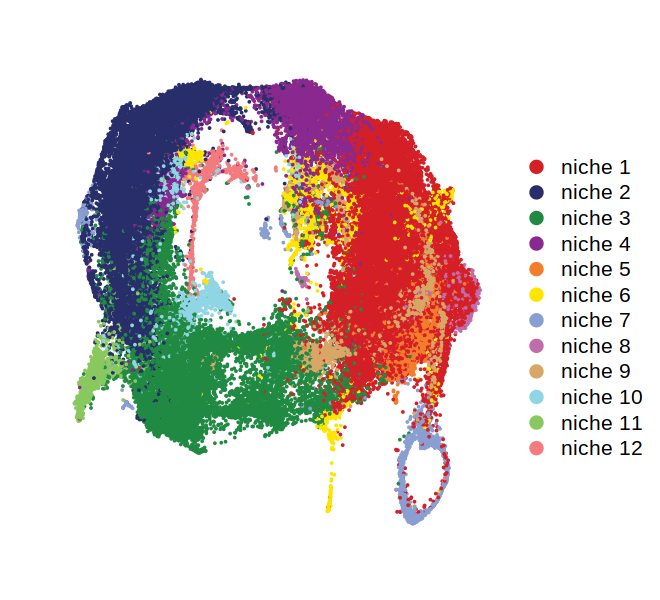

In [10]:
options(repr.plot.height = 5, repr.plot.width = 5.5)

p <- DimPlot(obj, group.by = "mol_niche", reduction = "umap_harmony_v2",
            cols = cols) +
    xlab("") + ylab("") + ggtitle("") +
    theme(axis.ticks = element_blank(),
         axis.text = element_blank(),
         legend.title = element_blank(),
         axis.line = element_blank())

p

ggsave("mol_niches_umap.pdf", plot = p, height = 5, width = 5.5)

In [7]:
suppressMessages(library(Nebulosa))
suppressMessages(library(cowplot))

DefaultAssay(obj) <- "SCT"

gene.list <- c(
    "GPAM", "FASN", # adipocytes
     "RYR2", "MYH7", "TNNT2",  # vCMs
    "VWF", "PECAM1", # Endo
    "DCN", "PDGFRA", # Fib
    "CD8A", "IL7R", # Lymphoid
    "KIT", "CPA3", # Mast cells
    "CD14", "C1QA", # Myeloid
    "NRXN1", # Neuronal 
    "RGS5", "ABCC9", # Pericyte
    "MKI67", # cycling
    "MYH11", "MYLK", # vSMCs
    "NPPA", "NPPB", "POSTN", "SPP1"
    )

for(gene in gene.list){
    p <- plot_density(obj, reduction = "umap_harmony_v2", feature = gene, pal = "plasma") + 
    xlab("") + ylab("") + ggtitle("") +
    theme_cowplot() +
    theme(axis.ticks = element_blank(),
         axis.text = element_blank(),
         axis.line = element_blank())

    #print(p)
    
    ggsave(glue::glue("mol_niches_umap_{gene}.pdf"), plot = p, height = 5, width = 6)
}

In [28]:
## compute niches proportion
df_plot <- obj@meta.data %>% 
            group_by(orig.ident, mol_niche) %>%
            summarise(counts = n()) %>%
            mutate(proportion = counts / sum(counts)) %>%
            as.data.frame()

df_anno <- read.csv("../../../../visiumSpatial/metadata/sample_annotation.csv") %>%
   subset(., select = c("sample_id", "patient_group")) %>%
   unique()


colnames(df_anno) <- c("orig.ident", "patient_group")

df_plot <- merge.data.frame(df_plot, df_anno)

head(df_plot)

`summarise()` has grouped output by 'orig.ident'. You can override using the `.groups` argument.



,orig.ident,mol_niche,counts,proportion,patient_group
,<chr>,<chr>,<int>,<dbl>,<chr>
1,AKK001_157785,niche_0,805,0.26119403,group_1
2,AKK001_157785,niche_1,883,0.28650227,group_1
3,AKK001_157785,niche_10,128,0.04153147,group_1
4,AKK001_157785,niche_2,443,0.14373783,group_1
5,AKK001_157785,niche_3,465,0.15087605,group_1
6,AKK001_157785,niche_4,264,0.08565866,group_1


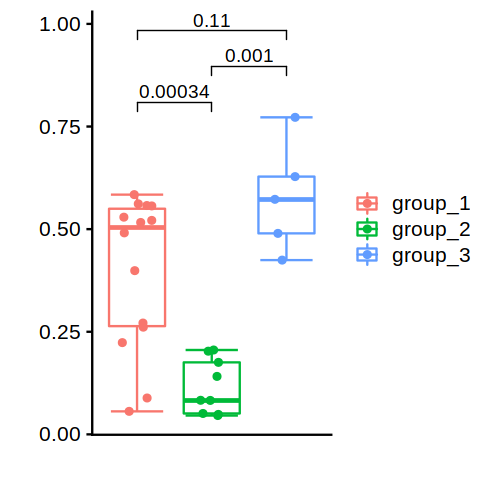

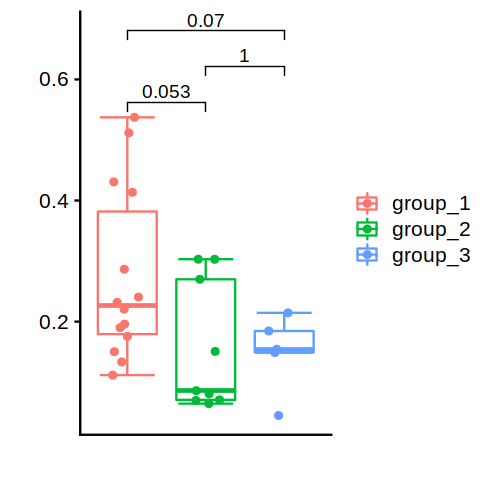

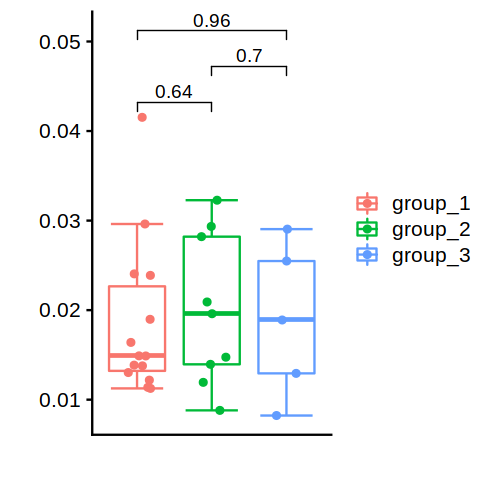

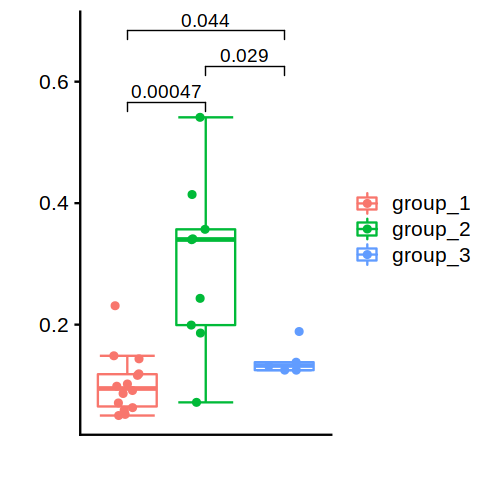

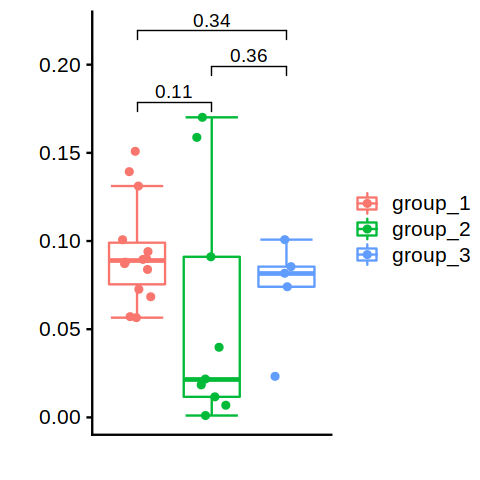

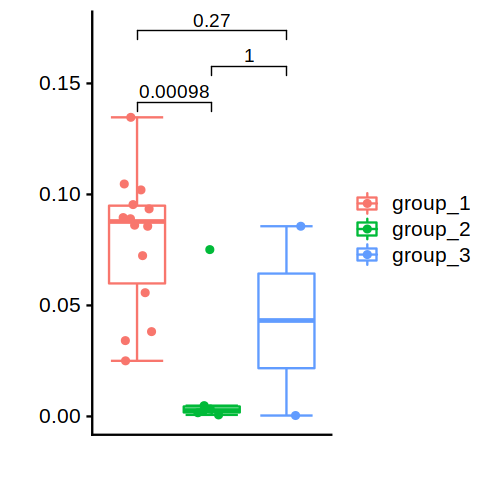

Warning message:
“Computation failed in `stat_signif()`:
not enough 'y' observations”
Warning message:
“Computation failed in `stat_signif()`:
not enough 'y' observations”


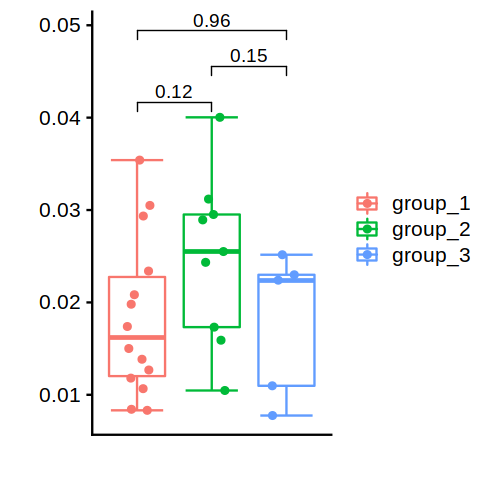

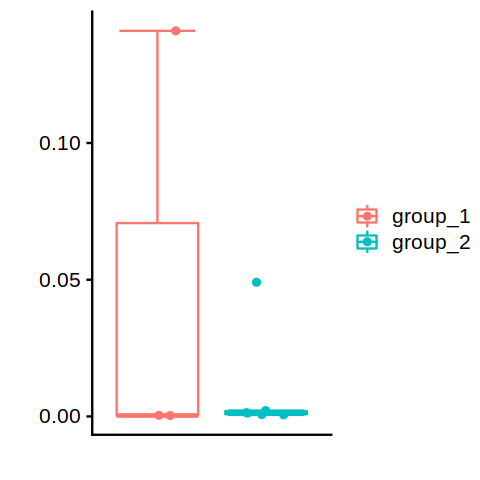

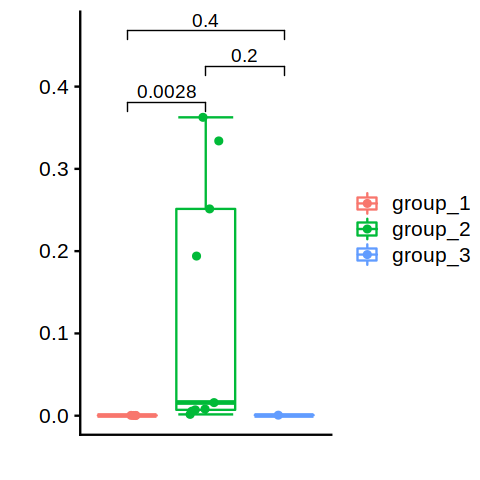

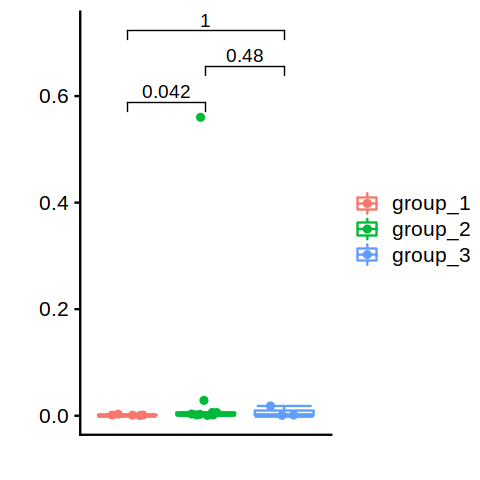

Warning message:
“Computation failed in `stat_signif()`:
not enough 'y' observations”
Warning message:
“Computation failed in `stat_signif()`:
not enough 'y' observations”


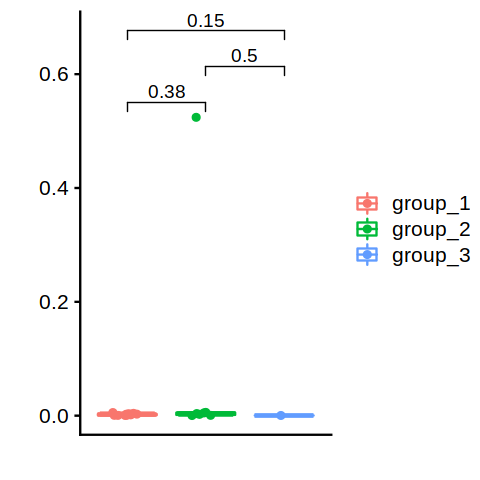

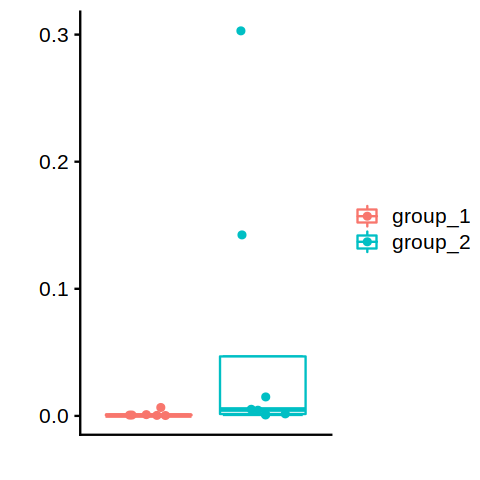

In [32]:
options(repr.plot.height = 4, repr.plot.width = 4)
#for(ct in unique(df$cell_type)){
for(niche in unique(df_plot$mol_niche)){
    df_plot_sub <- subset(df_plot, mol_niche == niche)
    
    p1 <- ggplot(df_plot_sub, aes(x = patient_group, 
                             y = proportion)) +
        Ipaper::geom_boxplot2(aes(color = patient_group)) +
    geom_point(aes(color = patient_group), position = position_jitterdodge(), size = 1.5) +
    ggpubr::stat_compare_means(comparisons = list(c("group_1", "group_2"),
                                         c("group_2", "group_3"),
                                         c("group_1", "group_3")),
                   method = "wilcox.test") +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_blank(),
         legend.title = element_blank(),
         axis.ticks.x = element_blank())
    
    print(p1)
    
    ggsave(glue::glue("{niche}.pdf"), plot=p1, height = 4, width = 4)

}